# CYGNSS Streamflow Modeling for Ungauged Basins (CSMUB)

This code combines the delineation of watersheds and the analysis of the CYGNSS watermask files to determine the surface water extent of each basin on a monthly time scale using the functions `crop_dem`, `process_basin` and `waterpx_count`. In addition, the function `read_gauge` loads the empirical streamflow data from text files downloaded from the Global Runoff Data Centre (GRDC) [link text](https://portal.grdc.bafg.de/applications/public.html?publicuser=PublicUser#dataDownload/Home). Lastly, it outputs a .csv file with the station name and the results of the analysis.

---


Author(s): Anna Valcarcel

Date of Creation: May 30, 2024

Last Updated: November 19, 2024

Version History:
*   v0.00 - Initial Version taken from demo codes
*   v0.01 - Added data visualization and functionality for reading GRDC data
*   v0.02 - Added .txt file readability for station date, functionality for downloading graphics/plots, and location details within plots.

*   v1.00 - Added functionality for loading station masterfile, cropping continent-scale DEM files, and calculating intersection of delineated and GRDC shape files to determine which shp to use





## Importing Packages

In [ ]:
!pip install pysheds netCDF4 fiona

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.5/91.5 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.6 MB/s eta 0:00:00
  Created wheel for pysheds: filename=pysheds-0.4-py3-none-any.whl size=90687 sha256=571f3e1f677eb8b5973c1530fdfb4c863fd4ad882b3f7437573a81fb4faade8f
  Stored in directory: /root/.cache/pip/wheels/8f/2b/0d/988f11a32332312c4d5dfe1720f891789e5b01853f6a842be6
Successfully built pysheds


In [ ]:
# IMPORT PACKAGES
from pysheds.grid import Grid
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas as gpd
import rasterio
import numpy as np
import pandas as pd
import fiona
import xarray as xr
import shapefile
import math
from scipy import stats
import os

import netCDF4 as nc
from netCDF4 import Dataset
from shapely.geometry import Point, shape, box
from shapely.vectorized import contains
from shapely.strtree import STRtree
import matplotlib.path as mpath
from google.colab import files

from rasterio.coords import BoundingBox
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.features import geometry_mask

## Define Functions

### Crop Continent-Scale DEM

In [ ]:
def crop_dem(input_tif, output_tif, center_lon, center_lat,area):
    """
    Crop a GeoTIFF file around a specified coordinate (center_lon, center_lat), save the cropped image,
    display the cropped area, and plot a scatter point at the center coordinates.
    """

    # # Define the path to the input and output TIFF files
    # input_tiff = "path/to/your/input.tif"
    # output_tif = "path/to/your/output_cropped.tif"
    if area < 10000:
      width = np.sqrt(area)*4 # width extending from center point to each edge of square
    else:
      width = np.sqrt(area)*2

    width = int(width)
    degrees = np.round(width/111.32,2)

    xmin = center_lon - degrees
    xmax = center_lon + degrees
    ymin = center_lat - degrees
    ymax = center_lat + degrees

    # Define the bounding box coordinates (left, bottom, right, top)
    bbox = (xmin, ymin, xmax, ymax)  # Replace with actual coordinates

    # Open the source TIFF file
    with rasterio.open(input_tif) as src:
        # Convert the bounding box to a GeoJSON-style geometry for rasterio.mask.mask
        bbox_geom = {
            "type": "Polygon",
            "coordinates": [[
                [bbox[0], bbox[1]],
                [bbox[0], bbox[3]],
                [bbox[2], bbox[3]],
                [bbox[2], bbox[1]],
                [bbox[0], bbox[1]]
            ]]
        }

        # Crop the image using the bounding box geometry
        out_image, out_transform = mask(src, [bbox_geom], crop=True)
        out_meta = src.meta.copy()

        # Update metadata to reflect the new cropped area
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            'crs': src.crs  # Ensure the CRS remains the same
        })

        # # Save the cropped data to a new GeoTIFF file with updated profile
        # profile = src.profile
        # profile.update({
        #     'height': height,
        #     'width': width,
        #     'transform': transform,
        #     'crs': src.crs  # Ensure CRS is preserved
        # })

        with rasterio.open(output_tif, 'w', **out_meta) as dst:
            dst.write(out_image)


    fig, ax = plt.subplots(figsize=(10, 10))

    # Calculate the extent of the image in geographic coordinates
    left = out_transform.c  # xmin
    right = out_transform.c + out_transform.a * out_image.shape[2]  # xmax
    top = out_transform.f  # ymax
    bottom = out_transform.f + out_transform.e * out_image.shape[1]  # ymin

    extent = (left, right, bottom, top)

    # Plot the image using rasterio's show function
    show(out_image, transform=out_transform, extent=extent, ax=ax, cmap='gray')
    # Set axis labels
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    # Add a scatter point at the center coordinate
    plt.scatter(lon, lat, color='red', marker='o', s=100, label="Center Point")
    plt.title("Cropped GeoTIFF Area with Center Point")
    plt.title("Cropped Image")
    plt.show()

### Delineate Basin from DEM

In [ ]:
def process_basin(tif_input, pour_lon, pour_lat,shp_name):
# ----------------------------

    # LOAD THE TIF FILE
    dset = rasterio.open(tif_input,mode='r+')
    # dset.nodata = -32767

    # OPTIONAL: change elevation values of ocean
    # rdbl = dset.read(1)
    # for i in range(0,len(rdbl)):
    #     list1 = rdbl[i]
    #     for j in range(0,len(list1)):
    #         if list1[j] == 32767:
    #             list1[j] = -1
    #     rdbl[i] = list1

    dset.close()


    # ----------------------------

    # Read elevation raster
    grid = Grid.from_raster(tif_input)
    dem = grid.read_raster(tif_input)

    # Condition DEM
    # ----------------------
    # Fill pits in DEM
    pit_filled_dem = grid.fill_pits(dem)

    # Fill depressions in DEM
    flooded_dem = grid.fill_depressions(pit_filled_dem)

    # Resolve flats in DEM
    inflated_dem = grid.resolve_flats(flooded_dem)

    # Determine D8 flow directions from DEM
    # ----------------------
    # Specify directional mapping
    dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

    # Compute flow directions
    # -------------------------------------
    fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

    # Calculate flow accumulation
    # --------------------------
    acc = grid.accumulation(fdir, dirmap=dirmap)
    acc[dem==0] = 0

    # Delineate a catchment
    # ---------------------
    # Specify pour point
    x = pour_lon
    y = pour_lat
    # print(x,y)

    # # Snap pour point to high accumulation cell
    # x_snap, y_snap = grid.snap_to_mask(acc > 1000000, (x, y))
    # # print(x_snap,y_snap)

    # Snap pour point to high accumulation cell
    acc_max = int(acc.max())
    # print(acc_max)
    power_ten = len(str(acc_max))
    # print(power_ten)
    snap_pt = 10**(int(power_ten) - 1)
    x_snap, y_snap = grid.snap_to_mask(acc > snap_pt, (x, y))

    # snap_pt = round(acc_max*0.9,-3)
    # x_snap, y_snap = grid.snap_to_mask(acc > snap_pt, (x, y))

    # Delineate the catchment
    catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
                          xytype='coordinate')


    # Crop and plot the catchment
    # ---------------------------
    # Clip the bounding box to the catchment
    grid.clip_to(catch)
    catch_view = grid.view(catch, dtype=np.uint8)

    # Create a vector representation of the catchment mask
    shapes = grid.polygonize(catch_view)

    # Specify schema
    schema = {
            'geometry': 'Polygon',
            'properties': {'LABEL': 'float:16'}
    }

    # Write shapefile
    shp_output = shp_name
    with fiona.open(shp_output, 'w',
                    driver='ESRI Shapefile',
                    crs=grid.crs.srs,
                    schema=schema) as c:
        i = 0
        for shape, value in shapes:
            rec = {}
            rec['geometry'] = shape
            rec['properties'] = {'LABEL' : str(value)}
            rec['id'] = str(i)
            c.write(rec)
            i += 1

    fig, ax = plt.subplots(figsize=(8,6))
    fig.patch.set_alpha(0)
    plt.grid('on', zorder=0)
    im = ax.imshow(acc, extent=catch.extent, zorder=1,
                  cmap='ocean',
                  norm=colors.LogNorm(1, acc.max()),
                  interpolation='bilinear')
    plt.colorbar(im, ax=ax, label='Upstream Cells')
    plt.imshow(np.where(catch_view,catch_view, np.nan), extent=grid.extent,zorder=2, cmap='Greys',alpha=0.3)
    plt.scatter(x_snap,y_snap, color='red', s=100, marker='o', zorder=3)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()
    plt.show()

    return shp_output

### Load Streamflow GRDC Station Data

In [ ]:
def get_stationdata(station_file):
  # Remove spaces in column names entirely
  df_Q = pd.read_csv(station_file, delimiter=';',encoding='utf-8',skiprows=38)
  # print(df_Q.head)

  df_Q.columns = df_Q.columns.str.replace(' ', '')
  df_Q['YYYY-MM-DD'] = df_Q['YYYY-MM-DD'].str.slice(0, 7)

  # Convert 'YYYY-MM-DD' column to datetime format
  df_Q['YYYY-MM-DD'] = pd.to_datetime(df_Q['YYYY-MM-DD'], format='%Y-%m')

  # Convert cutoff_date to datetime format
  start_date = pd.to_datetime('2018-08', format='%Y-%m')
  end_date = pd.to_datetime('2024-09', format='%Y-%m')

  # Filter the DataFrame to keep rows after '2018-08'
  df_filtered = df_Q[df_Q['YYYY-MM-DD'] >= start_date]
  df_filtered = df_filtered[df_filtered['YYYY-MM-DD'] <= end_date]

  # print(df_filtered.head)

  stream_gauge = df_filtered['Calculated'].values
  # print(len(stream_gauge))

  df_filtered['YYYY-MM-DD'] = df_filtered['YYYY-MM-DD'].dt.strftime('%Y-%m')
  dates = df_filtered['YYYY-MM-DD']
  dates = dates.reset_index()
  # print(dates)

  return stream_gauge, dates

### Calculate Water Pixel Count

In [ ]:
def waterpx_count(shp_input, nc_input):

  # Open NetCDF file and extract variables
  with nc.Dataset(nc_input) as dataset:
      watermask = dataset.variables['watermask'][:]
      latitude = dataset.variables['lat'][:]
      longitude = dataset.variables['lon'][:]

  # Load and reproject the shapefile
  shp = gpd.read_file(shp_input).to_crs('EPSG:4326')
  minlon, minlat, maxlon, maxlat = shp.geometry.total_bounds

  # Limit the NetCDF data to the bounding box of the shapefile
  lat_mask = (latitude >= minlat) & (latitude <= maxlat)
  lon_mask = (longitude >= minlon) & (longitude <= maxlon)

  watermask = watermask[lat_mask, :][:, lon_mask]
  lat_filtered = latitude[lat_mask]
  lon_filtered = longitude[lon_mask]

  # Step 1: Create a grid of filtered points
  lon_grid, lat_grid = np.meshgrid(lon_filtered, lat_filtered)
  points = np.column_stack([lon_grid.ravel(), lat_grid.ravel()])

  # Flatten the watermask array to align with points
  watermask_flat = watermask.ravel()

  # Step 2: Load the shapefile and get combined geometry
  shapefile_geom = shp.geometry.unary_union  # Combine all geometries in the shapefile

  # Step 3: Identify points intersecting the shapefile
  intersects_mask = contains(shapefile_geom, points[:, 0], points[:, 1])

  # Step 4: Filter the points and watermask values
  filtered_points = points[intersects_mask]
  filtered_watermask = watermask_flat[intersects_mask]

  # Step 5: Create geometries for intersecting points
  geometries = [Point(lon, lat) for lon, lat in filtered_points]

  # Step 6: Create a GeoDataFrame
  gdf = gpd.GeoDataFrame({'watermask': filtered_watermask}, geometry=geometries, crs='EPSG:4326')


  markercolormap2= colors.ListedColormap(['white', 'black','blue'])

  # Assuming gdf and water_percent are defined, and markercolormap2 is valid
  fig, ax = plt.subplots(1, 1, figsize=(10, 8))
  gdf.plot(column='watermask', ax=ax, vmin=0, vmax=3, legend=True, markersize=5, cmap=markercolormap2)
  ax.set_title(nc_input)
  ax.set_xlabel('Longitude')
  ax.set_ylabel('Latitude')
  plt.show()

  # Step 1: Filter the GeoDataFrame where 'watermask' is equal to 2
  filtered_gdf = gdf[gdf['watermask'] == 1]

  water_pixels = len(filtered_gdf)
  total_pixels = len(gdf)

  water_percent = (water_pixels / total_pixels) * 100

  return water_pixels, water_percent, total_pixels

## Crop Monthly NetCDF to Shape

In [1]:
def netcdf_totif(netcdf, output_tif):

    # Load NetCDF file and extract variables
    with nc.Dataset('nc_input.nc') as dataset:
        watermask = dataset.variables['watermask'][:]
        latitude = dataset.variables['lat'][:]
        longitude = dataset.variables['lon'][:]
    
    # Load and reproject the shapefile
    shp = gpd.read_file('shp_input.shp').to_crs('EPSG:4326')
    
    # Clip NetCDF data to shapefile bounding box
    minlon, minlat, maxlon, maxlat = shp.geometry.total_bounds
    lat_mask = (latitude >= minlat) & (latitude <= maxlat)
    lon_mask = (longitude >= minlon) & (longitude <= maxlon)
    
    watermask = watermask[lat_mask, :][:, lon_mask]
    lat_filtered = latitude[lat_mask]
    lon_filtered = longitude[lon_mask]
    
    # Create a mask based on shapefile geometry
    transform = Affine(
        (lon_filtered[-1] - lon_filtered[0]) / len(lon_filtered), 0, lon_filtered[0],
        0, (lat_filtered[-1] - lat_filtered[0]) / len(lat_filtered), lat_filtered[0]
    )
    
    shapes = [geom for geom in shp.geometry]
    mask = geometry_mask(shapes, transform=transform, invert=True, out_shape=watermask.shape)
    
    # Apply mask to the watermask
    filtered_watermask = np.where(mask, watermask, np.nan)
    
    # Export to GeoTIFF
    with rasterio.open(
        'output.tif',
        'w',
        driver='GTiff',
        height=filtered_watermask.shape[0],
        width=filtered_watermask.shape[1],
        count=1,
        dtype=filtered_watermask.dtype,
        crs='EPSG:4326',
        transform=transform,
    ) as dst:
        dst.write(filtered_watermask, 1)


NameError: name 'nc' is not defined

## Define Filepaths and Open Station Masterfile


In [ ]:
# DEFINE INPUTS FOR FUNCTION
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/CSWE_SMUB/Data

masterlist = '/content/drive/MyDrive/CSWE_SMUB/Data/GRDC_Stations_AllMonthly.csv'

Mounted at /content/drive
/content/drive/My Drive/CSWE_SMUB/Data


In [ ]:
stations_df = pd.read_csv(masterlist)
# print(stations_df)
station_num = stations_df['grdc_no']
# station_num

In [ ]:
monthly_path = '/content/drive/MyDrive/CSWE_SMUB/Data/Station_Data'

station_files = [os.path.join(monthly_path, f"{station_no}_Q_Month.txt") for station_no in station_num]

shp_log = np.zeros(len(station_files))

print(f"Loaded {len(station_files)} stations.")

Loaded 575 stations.


## Loop Through All Stations

### Crop Continent DEM

In [ ]:
# for i in range(0):
i = 0
data = stations_df.iloc[i]
# print(data)
number = data['grdc_no']
region = data['wmo_reg']
river = data['river']
name = data['station']
lat = data['lat']
lon = data['long']
area = data['area']
altitude = data['altitude']

print(number)
print(region)
print(name)
print(lon,lat)

# determine what continent DEM to use
# 1 - africa, 2 - asia, 3 - SA, 4 - NA/CA/caribbean, 5 - SW pacific, 6 - europe
if region == 1:
  dem = '/content/drive/MyDrive/CSWE_SMUB/Data/DEM/hyd_af_dem_30s.tif'
elif region == 2:
  dem = '/content/drive/MyDrive/CSWE_SMUB/Data/DEM/hyd_as_dem_30s.tif'
elif region == 3:
  dem = '/content/drive/MyDrive/CSWE_SMUB/Data/DEM/hyd_sa_dem_30s.tif'
elif region == 4:
  dem = '/content/drive/MyDrive/CSWE_SMUB/Data/DEM/hyd_na_dem_30s.tif'
elif region == 5:
  dem = '/content/drive/MyDrive/CSWE_SMUB/Data/DEM/hyd_au_dem_30s.tif'
elif region == 6:
  dem = '/content/drive/MyDrive/CSWE_SMUB/Data/DEM/hyd_eu_dem_30s.tif'

output_tif = f'/content/drive/MyDrive/CSWE_SMUB/Data/DEM/Stations/{number}_dem.tif'

1159100
1
VIOOLSDRIF (27811003)
17.72159144 -28.75798997


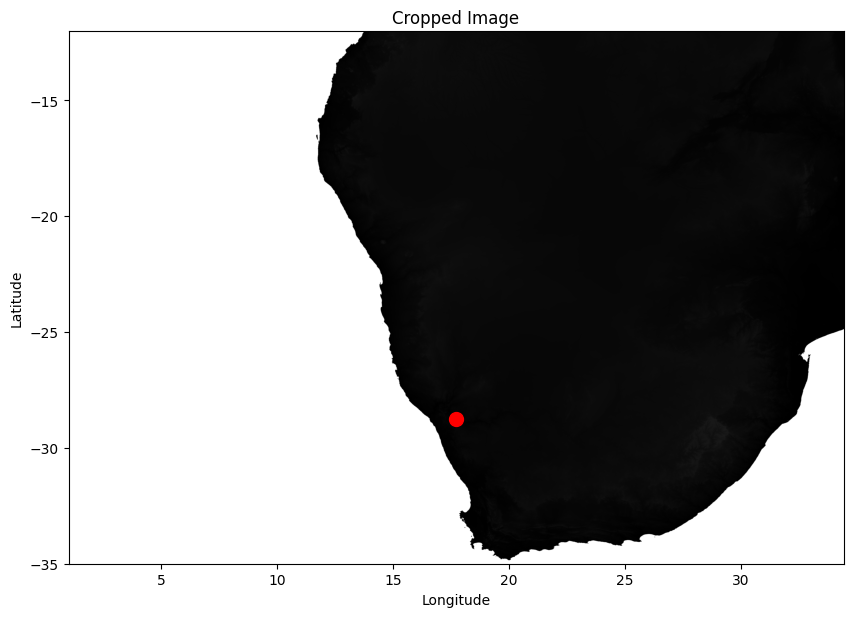

In [ ]:
crop_dem(dem, output_tif, lon, lat,area)

### Delineate Basin from Cropped DEM

In [ ]:
# LOAD THE TIF FILE
tif_input = output_tif
pour_point = [lon,lat]
print(pour_point)

# Define the path for the new folder
new_folder_path = f'/content/drive/MyDrive/CSWE_SMUB/Data/DEM/Stations/{number}/'

# Create the folder
os.makedirs(new_folder_path, exist_ok=True)

# Create new shapefile
shp_name = new_folder_path + f'{number}.shp'

[17.72159144, -28.75798997]


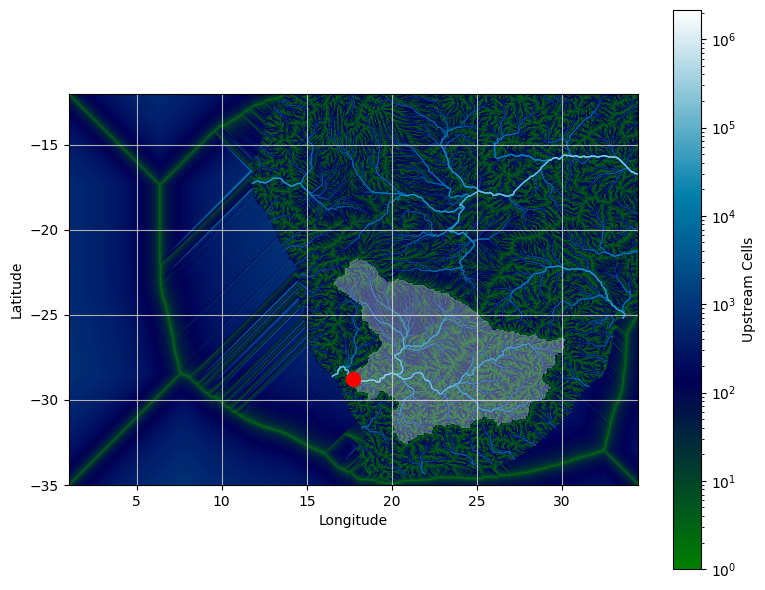

In [ ]:
shp_output = process_basin(tif_input, lon, lat,shp_name)

### Determine Shapefile for Use

In [ ]:
area

866486.0

In [ ]:
# Read the shapefiles
shapefile1 = gpd.read_file(shp_output) # delineated shapefile
shapefile2 = gpd.read_file(f'/content/drive/MyDrive/CSWE_SMUB/Data/DEM/Stations/{number}/{number}.shp') # GRDC shapefile

# Step 3: Reproject to a projected CRS (e.g., UTM Zone 33N, replace EPSG:32633 as appropriate)
projected_crs = shapefile2. to_crs(epsg=4326)  # Use an appropriate EPSG for your region
shapefile1 = shapefile1.to_crs(projected_crs.crs)
shapefile2 = shapefile2.to_crs(projected_crs.crs)

# Calculate the intersection
intersection = gpd.overlay(shapefile1, shapefile2, how='intersection')

# Calculate the area of the intersection
intersection_area = intersection.geometry.area.sum()
print(intersection_area)
inter_pcnt = ((intersection_area/10**6)/area)*100
print("Intersection percentage:", inter_pcnt)

if inter_pcnt >= 50:
  shapefile = shp_output
  shp_log[i] = 1

else:
    shapefile = f'/content/drive/MyDrive/CSWE_SMUB/Data/DEM/Stations/{number}/{number}.shp'
    shp_log[i] = 2

grdc_shp = shp_log[shp_log == 2]
print("Number of GRDC Shapefiles used: ", len(grdc_shp))

NameError: name 'gpd' is not defined

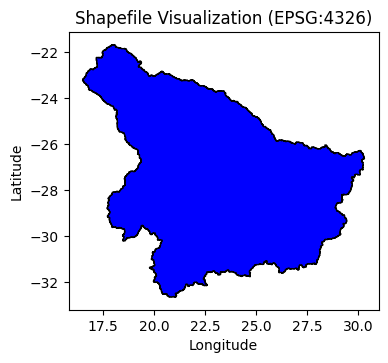

In [ ]:
# # Load and reproject shapefile
# shp = gpd.read_file(shapefile).to_crs('EPSG:4326')

# # Plot using GeoPandas
# shp.plot(figsize=(4,4), color='blue', edgecolor='black')
# plt.title("Shapefile Visualization (EPSG:4326)")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.show()

### Crop NetCDF

In [ ]:
# assign directory
directory = "/content/drive/MyDrive/CSWE_SMUB/Data/CYGNSS/"
file_list = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

In [ ]:
# Create empty numpy arrays with the correct size
num_files = len(file_list)
water_px = np.empty(num_files)
water_pcnt = np.empty(num_files) # CHANGE TO DATES
tot_px = np.empty(num_files)

In [ ]:
for i in range(0,len(dates)):
  date = dates['YYYY-MM-DD'][i]
  ncdf_list[i] = f'/content/drive/MyDrive/CSWE_SMUB/Data/Watermask/cyg.ddmi.{date}.l3.uc-berkeley-watermask-monthly.a31.d32.nc'

In [ ]:
for f, filename in enumerate(ncdf_list):
  if os.path.isfile(filename):
    # Define the path for the new folder
    new_folder_path = f'/content/drive/MyDrive/CSWE_SMUB/Data/DEM/Stations/{number}/'
    
    # Create the folder
    os.makedirs(new_folder_path, exist_ok=True)
    
    # Create new shapefile
    shp_name = new_folder_path + f'{number}.shp'
    tif_out = f"/content/drive/MyDrive/CSWE_SMUB/Data/"
    netcdf_totif(filename, tif_out)

### Calculate Water Pixel Percent

In [ ]:
# assign directory
directory = "/content/drive/MyDrive/CSWE_SMUB/Data/Watermask"
file_list = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

In [ ]:
# Create empty numpy arrays with the correct size
num_files = len(file_list)
water_px = np.empty(num_files)
water_pcnt = np.empty(num_files) # CHANGE TO DATES
tot_px = np.empty(num_files)

In [ ]:
for i in range(0,len(dates)):
  date = dates['YYYY-MM-DD'][i]
  ncdf_list[i] = f'/content/drive/MyDrive/CSWE_SMUB/Data/Watermask/cyg.ddmi.{date}.l3.uc-berkeley-watermask-monthly.a31.d32.nc'


In [ ]:
# THIS ONE WORKS
for f, filename in enumerate(ncdf_list):
  if os.path.isfile(filename):
    pixel_count, pixel_percent, total_pixels = waterpx_count(shp_output, filename)
    water_px[f] = pixel_count
    water_pcnt[f] = pixel_percent
    tot_px[f] = total_pixels

Output hidden; open in https://colab.research.google.com to view.

/content/drive/MyDrive/CSWE_SMUB/Data/Watermask/cyg.ddmi.2018-08.l3.uc-berkeley-watermask-monthly.a31.d32.nc


<ipython-input-44-6f83604cbf71>:29: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shapefile_geom = shp.geometry.unary_union  # Combine all geometries in the shapefile


KeyboardInterrupt: 

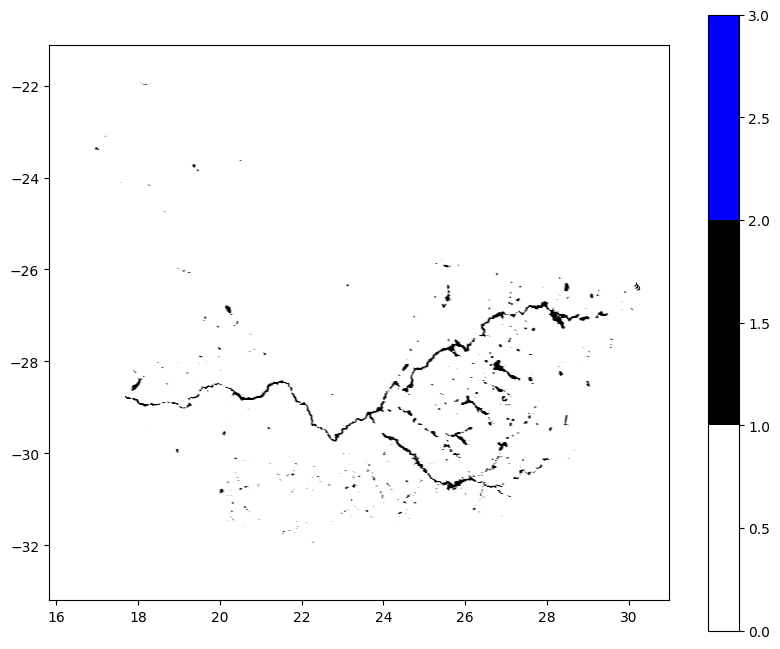

In [ ]:
# for i in range(0,len(watermask_dates)): #for all the
#   if watermask_dates[i] == dates['YYYY-MM-DD'][i]:
#     for f, filename in enumerate(ncdf_list):
#       pixel_count, pixel_percent, total_pixels = waterpx_count(shp_output, filename)
#       print(pixel_count,pixel_percent)
#       water_px[f] = pixel_count
#       water_pcnt[f] = pixel_percent
#       tot_px[f] = total_pixels